# Volume 3: ARMA Models
    Daniel Perkins
    MATH 407
    1/26/25

In [1]:
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.distributions import norm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.base.datetools import dates_from_str
from statsmodels.tsa.api import VARMAX
import statsmodels.api as sm
import pandas as pd

## Helper Functions

In [2]:
def kalman(F, Q, H, time_series):
    # Get dimensions
    dim_states = F.shape[0]

    # Initialize variables
    # covs[i] = P_{i | i-1}
    covs = np.zeros((len(time_series), dim_states, dim_states))
    mus = np.zeros((len(time_series), dim_states))

    # Solve of for first mu and cov
    covs[0] = np.linalg.solve(np.eye(dim_states**2) - np.kron(F, F), 
            np.eye(dim_states**2) @ Q.flatten()).reshape((dim_states, dim_states))
    mus[0] = np.zeros((dim_states,))

    # Update Kalman Filter
    for i in range(1, len(time_series)):
        # Assume u, R = 0
        SkInv = np.linalg.solve(H @ covs[i-1] @ H.T, np.eye(H.shape[0]))
        Kk_H_Pkk = covs[i-1] @ (H.T @ (SkInv @ (H @ covs[i-1])))
        covs[i] = F @ ((covs[i-1] - Kk_H_Pkk) @ F.T) + Q
        mus[i] = F @ mus[i-1] + (F @ (covs[i-1] @ (H.T @ SkInv))) @ (time_series[i-1] - H @ mus[i-1])
    return mus, covs

def state_space_rep(phis, thetas, mu, sigma):
    # Initialize variables
    dim_states = max(len(phis), len(thetas)+1)
    dim_time_series = 1 # hardcoded for 1d time_series

    F = np.zeros((dim_states, dim_states))
    Q = np.zeros((dim_states, dim_states))
    H = np.zeros((dim_time_series, dim_states))

    # Create F
    F[0, :len(phis)] = phis
    F[1:, :-1] = np.eye(dim_states - 1)
    # Create Q
    Q[0][0] = sigma**2
    # Create H
    H[0][0] = 1.
    H[0][1:len(thetas)+1] = thetas

    return F, Q, H, dim_states, dim_time_series

## Problem 1

In [35]:
def arma_forecast_naive(file='weather.npy', p=2, q=1, n=20):
    """
    Perform ARMA(p,q) on data. Let error terms be drawn from
    a standard normal, let c be 0, the phis be 0.5, and the 
    thetas be 0.1. Predict the next n observations and plot 
    the original data with the predictions.

    Parameters:
        file (str): data file
        p (int): order of autoregressive model
        q (int): order of moving average model
        n (int): number of future predictions
    """
    # Define parameters
    c, phi, theta = 0, 0.5, 0.1
    
    # Load in data
    data = np.load(file)
    z = np.diff(data)  # Take the difference to make it covariance stationary
    eps = norm.rvs(size=len(z)+n)
    
    # Plug things into the formula
    predictions = np.concatenate((z, np.empty(n)))
    for t in range(len(z), len(z)+n):
        AR = phi*np.sum(predictions[t-p:t])
        MA = theta*np.sum(eps[t-q:t])
        predictions[t] = c + AR + MA  + eps[t]
        
    # Plot it
    ts = np.arange(len(predictions))
    plt.xlabel("Day of the Month")
    plt.ylabel("Change in Temperature (C)-mu=0")
    plt.title("Arma(2,1) Naive Forecast")
    plt.plot(ts[:len(z)], predictions[:len(z)], label="Old Data")
    plt.plot(ts[len(z):], predictions[len(z):], label="New Data")
    plt.legend()
    plt.show()

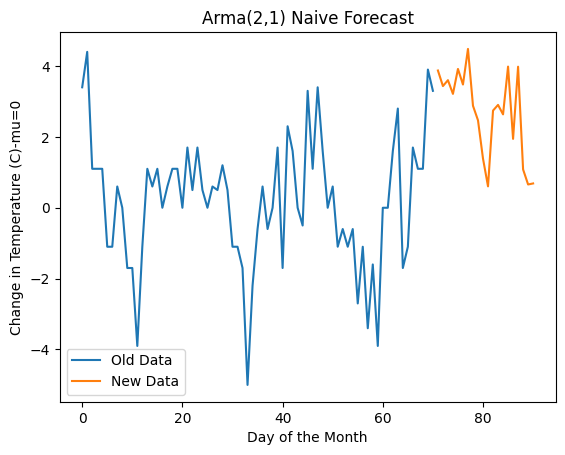

In [40]:
arma_forecast_naive()

## Problem 2

In [92]:
def arma_likelihood(filename='weather.npy', phis=np.array([0.9]), thetas=np.array([0]), mu=17., std=0.4):
    """
    Transfer the ARMA model into state space.
    Return the log-likelihood of the ARMA model.

    Parameters:
        file (str): data file
        phis (ndarray): coefficients of autoregressive model
        thetas (ndarray): coefficients of moving average model
        mu (float): mean of errorm
        std (float): standard deviation of error

    Return:
        log_likelihood (float)
    """
    # Load in data
    data = np.load(filename)
    z = np.diff(data)  # Take the difference to make it covariance stationary
    
    # Get mus and covs using the provided function
    F, Q, H, dim_states, dim_time_series = state_space_rep(phis, thetas, mu, std)
    mus, covs = kalman(F, Q, H, z-mu)
    
    # Formula 24.1
    log_likelihood = 0
    for t in range(len(z)):
        zi, x, P = z[t], mus[t], covs[t]
        
        mean = H @ x + mu
        mean = mean[0]  # Convert to float
        var = H @ P @ H.T
        var = var[0,0]  # Convert to float
        
        log_likelihood += norm.logpdf(zi, loc=mean, scale=np.sqrt(var))
    
    return log_likelihood

In [93]:
log_likelihood = arma_likelihood()
print(log_likelihood)

-1375.1805469978774


## Problem 3

In [98]:
def model_identification(filename='weather.npy', p_max=4, q_max=4):
    """
    Identify parameters to minimize AIC of ARMA(p,q) model

    Parameters:
        file (str): data file
        p_max (int): maximum order of autoregressive model
        q_max (int): maximum order of moving average model

    Returns:
        phis (ndarray (p,)): coefficients for AR(p)
        thetas (ndarray (q,)): coefficients for MA(q)
        mu (float): mean of error
        std (float): std of error
    """
    # Load in data
    data = np.load(filename)
    z = np.diff(data)  # Take the difference to make it covariance stationary
    
    best_AIC = np.inf
    best_phis = None
    best_thetas = None
    best_mu = None
    best_std = None
    
    # Iterate through all sizes
    for p in range(1, p_max+1):
        for q in range(1, q_max + 1):
            
            # Function f as defined in the yellow box
            def f(x):  # x contains the phis, thetas, mu, and std
                try: return -1*arma_likelihood(filename, phis=x[:p], thetas=x[p:p+q], mu=x[-2], std=x[-1])
                except np.linalg.LinAlgError: return np.inf

            # Create initial point
            k = p + q + 2
            x0 = np.zeros(k)
            x0[-2], x0[-1] = z.mean(), z.std()
            sol = minimize(f, x0, method = "SLSQP")["x"]
            
            # Compute the AIC
            AIC = 2*k*(1 + (k+1)/(len(z)-k)) + 2*f(sol)

            # If it is minimized, store the values
            if AIC < best_AIC:
                best_AIC = AIC
                best_phis = sol[:p]
                best_thetas = sol[p:p+q]
                best_mu = sol[-2]
                best_std = sol[-1]
                
    return best_phis, best_thetas, best_mu, best_std

In [99]:
best_phis, best_thetas, best_mu, best_std = model_identification()

print("Best Phis:", best_phis)
print("Best Thetas:", best_thetas)
print("Best Mu:", best_mu)
print("Best Std:", best_std)

/tmp/ipykernel_131043/3502028995.py:34: RuntimeWarning: invalid value encountered in sqrt
  log_likelihood += norm.logpdf(zi, loc=mean, scale=np.sqrt(var))
/home/dbp52/.acme-venv/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Best Phis: [0.72135378]
Best Thetas: [-0.26246421]
Best Mu: 0.35978624107178275
Best Std: 1.5568374032472605


## Problem 4

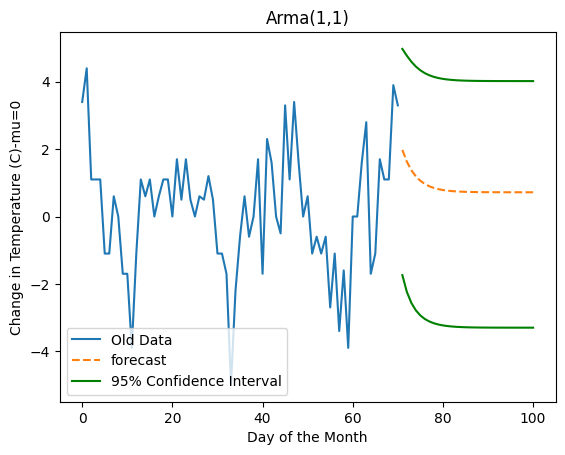

In [145]:
def arma_forecast(filename='weather.npy', phis=np.array([0]), thetas=np.array([0]), mu=0, std=0, n=30):
    """
    Forecast future observations of data.

    Parameters:
        file (str): data file
        phis (ndarray (p,)): coefficients of AR(p)
        thetas (ndarray (q,)): coefficients of MA(q)
        mu (float): mean of ARMA model
        std (float): standard deviation of ARMA model
        n (int): number of forecast observations
    """
    # Load in data
    data = np.load(filename)
    z = np.diff(data)  # Take the difference to make it covariance stationary
    
    F, Q, H, dim_states, dim_time_series = state_space_rep(phis, thetas, mu, std)
    z_minus_mu = z-mu
    mus, covs = kalman(F, Q, H, z_minus_mu)
    
    # Start with the last computed values
    x = mus[-1]
    P = covs[-1]
    
    means = np.empty(n)
    vars = np.empty(n)
    upper_conf = np.empty(n)
    lower_conf = np.empty(n)
    
    for i in range(n):
        # Find x and P
        x = F @ x
        P = F @ P @ F.T + Q
        # Equations 24.16 and 24.17
        mean = H @ x + mu
        var = H @ P @ H.T
        # Store it
        means[i] = mean[0] + mu
        vars[i] = var[0,0]
        conf_interval = norm.interval(0.95, loc=mean, scale=np.sqrt(var[0,0]))
        upper_conf[i] = conf_interval[1][0]
        lower_conf[i] = conf_interval[0][0]
        
    # Plot it
    ts = np.arange(len(z))
    plt.xlabel("Day of the Month")
    plt.ylabel("Change in Temperature (C)-mu=0")
    plt.title("Arma(1,1)")
    plt.plot(ts, z, label="Old Data")
    plt.plot(np.arange(len(z), len(z)+n), means, linestyle='--', label="forecast")
    plt.plot(np.arange(len(z), len(z)+n), upper_conf, color="green", label="95% Confidence Interval")
    plt.plot(np.arange(len(z), len(z)+n), lower_conf, color="green")
    plt.legend()
    plt.show()
        

arma_forecast(filename='weather.npy', phis=best_phis, 
            thetas=best_thetas, mu=best_mu, std=best_std, n=30)

## Problem 5

In [ ]:
def sm_arma(filename='weather.npy', p_max=3, q_max=3, n=30):
    """
    Build an ARMA model with statsmodel and
    predict future n values.

    Parameters:
        filename (str): data filename
        p_max (int): maximum order of autoregressive model
        q_max (int): maximum order of moving average model
        n (int): number of values to predict

    Return:
        aic (float): aic of optimal model
    """
    raise NotImplementedError('Problem 5 Incomplete') 

## Problem 6

In [ ]:
def sm_varma(start='1959-09-30', end='2012-09-30'):
    """
    Build an VARMAX model with statsmodel and
    forecast from start date until end date.

    Parameters:
        start (str): the data at which to begin forecasting
        end (str): the date at which to stop forecasting

    Return:
        aic (float): aic of optimal model
    """
    raise NotImplementedError('Problem 6 Incomplete') 